In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, Concatenate, Flatten
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading  the test and train data and naming the columns

column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "target"]

dftrain = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kddcup.data_10_percent.gz', compression='gzip', names=column_names)

In [ ]:
attacks_types = {
    'normal.': 'normal', 'back.': 'dos', 'buffer_overflow.': 'u2r', 'ftp_write.': 'r2l', 'guess_passwd.': 'r2l',
    'imap.': 'r2l', 'ipsweep.': 'probe', 'land.': 'dos', 'loadmodule.': 'u2r', 'multihop.': 'r2l', 'neptune.': 'dos',
    'nmap.': 'probe', 'perl.': 'u2r', 'phf.': 'r2l', 'pod.': 'dos', 'portsweep.': 'probe', 'rootkit.': 'u2r', 'satan.': 'probe',
    'smurf.': 'dos', 'spy.': 'r2l', 'teardrop.': 'dos', 'warezclient.': 'r2l', 'warezmaster.': 'r2l'}
dftrain['Attack Type'] = dftrain.target.apply(lambda r:attacks_types[r])

In [ ]:
dftrain.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,Attack Type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


In [ ]:
dftrain['flag'].unique()

array(['SF', 'S1', 'REJ', 'S2', 'S0', 'S3', 'RSTO', 'RSTR', 'RSTOS0',
       'OTH', 'SH'], dtype=object)

In [ ]:
dftrain.shape

(494021, 43)

In [ ]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

In [ ]:
dftrain['Attack Type'].value_counts()

dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: Attack Type, dtype: int64

In [ ]:
dftrain.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:

# Splitting X and Y
X = dftrain.iloc[:, :-2].values
y = dftrain.iloc[:, -1].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X , y , test_size=0.2, random_state=42)


In [ ]:
#Separating x to numerical and categorical
numerical_indices = [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                     24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
categorical_indices = [1, 2, 3]


X_train_numeric = X_train[:, numerical_indices]
X_train_categorical = X_train[:, categorical_indices]


In [ ]:
# Standardizing the features for faster convergence
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train_numeric)


In [ ]:
#one hot encoding y_train to create target
target = np.array([]).reshape(0, 5)
for i in y_train:
    one_hot_label = np.zeros(5)  # one-hot encoded vector
    if i == 'normal':
        one_hot_label[0] = 1.0
    elif i == 'dos':
        one_hot_label[1] = 1.0
    elif i == 'u2r':
        one_hot_label[2] = 1.0
    elif i == 'r2l':
        one_hot_label[3] = 1.0
    else:
        one_hot_label[4] = 1.0

    target = np.vstack((target, one_hot_label))
print('Target shape is:', target.shape)
target

Target shape is: (395216, 5)


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
#creating the input layers
input_layer_numeric = Input(shape=(X_train_numeric.shape[1],))

# embedding layers for categorical data
embedding_layers = []
input_layers_categorical = []
for index in categorical_indices:
    input_layer = Input(shape=(1,))

    num_unique_values = len(np.unique(X_train[:, index]))
    embedding_dim = num_unique_values // 2
    embedding_layer = Embedding(input_dim=num_unique_values, output_dim=embedding_dim)(input_layer)
    embedding_layer = Flatten()(embedding_layer)

    embedding_layers.append(embedding_layer)
    input_layers_categorical.append(input_layer
)

# Concatenating the numerical and categorical inputs
concatenated = Concatenate()( [input_layer_numeric] +embedding_layers )

hidden_layer1 = Dense(64, activation='relu')(concatenated) #2 hidden layers
hidden_layer2 = Dense(32, activation='relu')(hidden_layer1)
output_layer = Dense(5, activation='softmax')(hidden_layer2) # softmax for output activation

model = Model(inputs=[input_layer_numeric] + input_layers_categorical, outputs=output_layer)
optimizer = Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])#binary crossentropy as loss function

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_indices = [1, 2, 3]
for col_index in categorical_indices:
    label_encoder = LabelEncoder()
    X_train[:, col_index] = label_encoder.fit_transform(X_train[:, col_index])

In [ ]:
X_train = X_train.astype('float64')

In [ ]:
#  Training the neural network

history = model.fit([X_train_numeric]+[X_train[:, index] for index in categorical_indices], target, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
2471/2471 [==============================] - 19s 7ms/step - loss: 0.0897 - accuracy: 0.9711 - val_loss: 0.0123 - val_accuracy: 0.9912
Epoch 2/10
2471/2471 [==============================] - 16s 7ms/step - loss: 0.0078 - accuracy: 0.9950 - val_loss: 0.0045 - val_accuracy: 0.9971
Epoch 3/10
2471/2471 [==============================] - 16s 6ms/step - loss: 0.0037 - accuracy: 0.9977 - val_loss: 0.0030 - val_accuracy: 0.9984
Epoch 4/10
2471/2471 [==============================] - 16s 7ms/step - loss: 0.0024 - accuracy: 0.9986 - val_loss: 0.0023 - val_accuracy: 0.9988
Epoch 5/10
2471/2471 [==============================] - 16s 7ms/step - loss: 0.0018 - accuracy: 0.9990 - val_loss: 0.0020 - val_accuracy: 0.9989
Epoch 6/10
2471/2471 [==============================] - 17s 7ms/step - loss: 0.0015 - accuracy: 0.9991 - val_loss: 0.0018 - val_accuracy: 0.9990
Epoch 7/10
2471/2471 [==============================] - 17s 7ms/step - loss: 0.0014 - accuracy: 0.9992 - val_loss: 0.0017 - val_ac

In [ ]:
model.save('NIDS.keras')

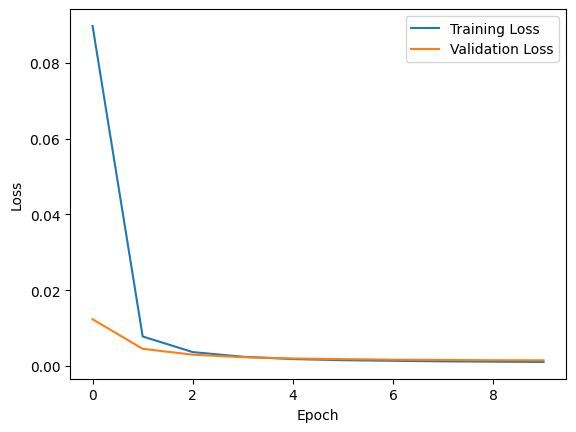

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

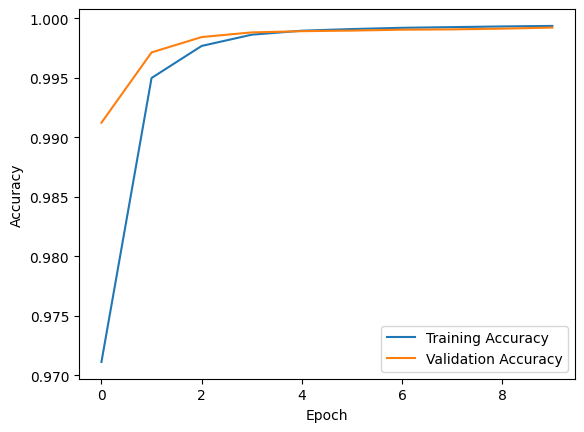

In [203]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Gradio Interface**  (successfully worked on the jupyter notebook. There were some installation issues related to gradio in colab)

In [ ]:
import gradio as gr
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Loading the saved model
loaded_model = load_model('C:/Users/PRATHAM/Downloads/NIDS.h5')
scaler = StandardScaler()
label_encoder = LabelEncoder()

def preprocess(file):
  data = pd.read_csv(file,compression='gzip', names=column_names)
  attacks_types = {
    'normal.': 'normal', 'back.': 'dos', 'buffer_overflow.': 'u2r', 'ftp_write.': 'r2l', 'guess_passwd.': 'r2l',
    'imap.': 'r2l', 'ipsweep.': 'probe', 'land.': 'dos', 'loadmodule.': 'u2r', 'multihop.': 'r2l', 'neptune.': 'dos',
    'nmap.': 'probe', 'perl.': 'u2r', 'phf.': 'r2l', 'pod.': 'dos', 'portsweep.': 'probe', 'rootkit.': 'u2r', 'satan.': 'probe',
    'smurf.': 'dos', 'spy.': 'r2l', 'teardrop.': 'dos', 'warezclient.': 'r2l', 'warezmaster.': 'r2l'}
  data['Attack Type'] = data.target.apply(lambda r:attacks_types[r])
  categorical_indices = [1, 2, 3]
  for col_index in categorical_indices:
    data.iloc[:, col_index] = label_encoder.fit_transform(data.iloc[:, col_index])

  data = data.drop(['target', 'Attack Type'], axis=1)
  data = data.iloc[:,:].values
  print(data)
  return data
# Defining the prediction function
def predict_csv(file):
    # Preprocess the data if needed (adjust this based on your preprocessing steps)
    data = preprocess(file)
    numerical_indices = [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                     24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
    categorical_indices = [1, 2, 3]

    numeric = data[:, numerical_indices]
    categorical = data[:, categorical_indices]
    numeric = scaler.fit_transform(numeric)
    print(numeric.shape)
    print(categorical.shape)
    predictions = loaded_model.predict([numeric]+[data[:, index] for index in categorical_indices])
    predicted_labels = np.argmax(predictions, axis=1)

    # Creating a dictionary to map indices to categories
    index_to_category = {
        0: 'normal',
        1: 'dos',
        2: 'u2r',
        3: 'r2l',
        4: 'other'
    }

    # Mapping indices to categories using the dictionary
    predicted_categories = np.vectorize(index_to_category.get)(predicted_labels)
    return f"Network Intrusion Detected, Attack Type: {predicted_categories}"


# Defining the Gradio interface
iface = gr.Interface(
    fn=predict_csv,
    inputs="file",
    outputs="text",
    live=True,
    title="Network Intrusion Detection System",
    description="Upload a CSV file, and the model will detect whether there is any network intrusion or not and the type of attack.",
)

# Launching the Gradio interface
iface.launch()

ImportError: ignored

In [ ]:
predictions = predict_csv('/content/drive/MyDrive/Colab Notebooks/kddcup.data_10_percent.gz')
print(predictions)
unique_values = np.unique(predictions)
unique_values, counts = np.unique(predictions, return_counts=True)

# Print or use the unique values and counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count} occurrences")

<ipython-input-76-46cc8dfc09b9>:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, col_index] = label_encoder.fit_transform(data.iloc[:, col_index])
<ipython-input-76-46cc8dfc09b9>:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, col_index] = label_encoder.fit_transform(data.iloc[:, col_index])
<ipython-input-76-46cc8dfc09b9>:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[

15439/15439 [==============================] - 35s 2ms/step
['normal' 'normal' 'normal' ... 'normal' 'normal' 'normal']
dos: 391489 occurrences
normal: 97318 occurrences
other: 4066 occurrences
r2l: 1118 occurrences
u2r: 30 occurrences


In [ ]:
#preparing x_test for input
def prepare(X_test):
    numerical_indices = [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                     24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
    categorical_indices = [1, 2, 3]

    X_test_numeric = X_test[:, numerical_indices]
    X_test_categorical = X_test[:, categorical_indices]

    X_test_numeric = scaler.fit_transform(X_test_numeric)

    test_target = np.array([]).reshape(0, 5)
    for i in y_test:
      one_hot_label = np.zeros(5)  # one-hot encoded vector
      if i == 'normal':
          one_hot_label[0] = 1.0
      elif i == 'dos':
          one_hot_label[1] = 1.0
      elif i == 'u2r':
          one_hot_label[2] = 1.0
      elif i == 'r2l':
          one_hot_label[3] = 1.0
      else:
          one_hot_label[4] = 1.0

      test_target = np.vstack((target, one_hot_label))

    return X_test_numeric, X_test_categorical, test_target